In [1]:
from time_stitches import *
from step1_functions import *
from features import get_jerk
from functions import *
import os

In [2]:
def get_path_length_g(time, pos):

    dt = 1/120
    diff_time = np.diff(time, axis=0)
    mask_step_bigger_dt = (diff_time>dt)

    pos_selected = pos[1:][~mask_step_bigger_dt]

    # Calculate the differences in positions between consecutive samples
    differences = np.diff(pos_selected, axis=0)
    # Calculate the Euclidean distance (path length) between consecutive points
    distances = np.linalg.norm(differences, axis=1)
    # Sum up the distances to get the total path length
    total_path_length = np.sum(distances)
    return total_path_length

In [3]:
def compute_v_acc_jerk(data_one_stitch): #data including time and position
    dt = 1/120
    diff_t_x_y_z = np.diff(data_one_stitch, axis = 0)
    mask_step_bigger_dt = (diff_t_x_y_z[:,0]>dt)
    t_x_y_z = diff_t_x_y_z[~mask_step_bigger_dt]
    v_x_y_z = [t_x_y_z[:,1]/t_x_y_z[:,0], t_x_y_z[:,2]/t_x_y_z[:,0], t_x_y_z[:,3]/t_x_y_z[:,0]]
    acc_x_y_z = [v_x_y_z[0]/t_x_y_z[:,0], v_x_y_z[1]/t_x_y_z[:,0], v_x_y_z[2]/t_x_y_z[:,0]]
    jerk_x_x_z = [acc_x_y_z[0]/t_x_y_z[:,0], acc_x_y_z[1]/t_x_y_z[:,0], acc_x_y_z[2]/t_x_y_z[:,0]]
    return v_x_y_z, acc_x_y_z, jerk_x_x_z

In [4]:
def get_mean_std_v(v):
    return np.mean(np.linalg.norm(v, axis=0)), np.std(np.linalg.norm(v, axis=0))

In [5]:
def get_list_idle_time(subject, i, list_np_segmented_nh_rec, list_np_segmented_tw_rec):
    needle_holder_rec = pd.read_csv(f'Data/Sync_data/S_{subject}_NH_reconstructed.csv')
    tweezers_rec = pd.read_csv(f'Data/Sync_data/S_{subject}_TW_reconstructed.csv')
    dict_segment_time = full_segments_time[i]
    
    full_time_segment_tw = pd_2_numpy_and_segment(tweezers_rec, dict_segment_time)
    full_time_segment_nh = pd_2_numpy_and_segment(needle_holder_rec, dict_segment_time)

    list_idle_nh = []
    list_idle_tw = []
    for s in range(8):
        effective_t_nh = list_np_segmented_nh_rec[s][:,0]
        effective_t_tw = list_np_segmented_tw_rec[s][:,0]
        tot_time_nh = full_time_segment_nh[s][:,0]
        tot_time_tw = full_time_segment_tw[s][:,0]
        idle_time_nh = tot_time_nh.shape[0] * (1.0 / 120.0) - effective_t_nh.shape[0] * (1.0 / 120.0)
        idle_time_tw = tot_time_tw.shape[0] * (1.0 / 120.0) - effective_t_tw.shape[0] * (1.0 / 120.0)
        list_idle_nh.append(idle_time_nh)
        list_idle_tw.append(idle_time_tw)
    return list_idle_nh, list_idle_tw


In [6]:
def get_economy_of_volume(segment_pos, PL):
    x = segment_pos[:,0]
    y = segment_pos[:,1]
    z = segment_pos[:,2]

    EOV = ((np.max(x)-np.min(x))*(np.max(y)-np.min(y))*(np.max(z)-np.min(z)))**(1/3)/PL
    return EOV

In [7]:
def get_mean_std_curvature (v, acc):
    v = np.array(v)
    acc = np.array(acc)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        curvature = np.where(v == 0, np.nan, (v * acc) / (v**3))
    return np.nanmean(curvature), np.nanstd(curvature)

In [8]:
def inverse_quaternion(quaternion):
    q1, q2, q3, q4 = quaternion
    inverse = [q1, -q2, -q3, -q4]/(q1**2 + q2**2 +q3**2 +q4**2) #nécessaire si normalisé???
    return inverse

In [9]:
def get_orientation_change(quaternion_nh, quaternion_tw): #SUPPRIMER UNE FOIS QUE L'AUTRE FONCTIONNE
    #compute unitary quaternion
    norm_quaternion_nh =  quaternion_nh/np.linalg.norm(quaternion_nh, axis=0)
    norm_quaternion_tw =  quaternion_tw/np.linalg.norm(quaternion_tw, axis=0)

    #compute inverse (according to wikipedia formula)
    inverse_nh = []
    for i in range (len(norm_quaternion_nh)):
        inverse_nh.append(inverse_quaternion(norm_quaternion_nh[i,:]))
    inverse_tw = []
    for n in range (len(norm_quaternion_tw)):
        inverse_tw.append(inverse_quaternion(norm_quaternion_tw[n,:]))

    #compute rotation difference
    deltaQ_nh = []
    for j in range (len(norm_quaternion_nh)-1):
        q = np.array(norm_quaternion_nh[j])
        qinv = np.array(inverse_nh[j+1])
        deltaQ_nh.append((q*qinv).tolist())
    
    deltaQ_tw = []
    for j in range (len(norm_quaternion_tw)-1):
        q = np.array(norm_quaternion_tw[j])
        qinv = np.array(inverse_tw[j+1])
        deltaQ_tw.append((q*qinv).tolist())

    #compute orientation change
    deltaTeta_nh = []
    for p in range (len(deltaQ_nh)):
        delta_orientation = 2*np.cos(deltaQ_nh[p][0])**(-1)
        deltaTeta_nh.append(delta_orientation)

    deltaTeta_tw = []
    for p in range (len(deltaQ_tw)):
        delta_orientation = 2*np.cos(deltaQ_tw[p][0])**(-1)
        deltaTeta_tw.append(delta_orientation)
    
    return deltaTeta_nh, deltaTeta_tw
    

In [10]:
def get_orientation_change(quaternion):
    #compute unitary quaternion
    norm_quaternion =  quaternion/np.linalg.norm(quaternion, axis=0)
    
    #compute inverse (according to wikipedia formula)
    inverse = []
    for i in range (len(norm_quaternion)):
        inverse.append(inverse_quaternion(norm_quaternion[i,:]))

    #compute rotation difference
    deltaQ = []
    for j in range (len(norm_quaternion)-1):
        q = np.array(norm_quaternion[j])
        qinv = np.array(inverse[j+1])
        deltaQ.append((q*qinv).tolist())

    #compute orientation change
    deltaTeta = []
    for p in range (len(deltaQ)):
        delta_orientation = 2*np.cos(deltaQ[p][0])**(-1)
        deltaTeta.append(delta_orientation)
    
    return deltaTeta
    

In [11]:
def get_angular_displacement(quaternion):
    deltaTeta = get_orientation_change(quaternion)
    angular_disp = np.sum(np.abs(deltaTeta))
    return angular_disp

In [12]:
def get_rate_of_orientation_change(list_np_segmented):
    time = list_np_segmented[:,0]
    quaternion = list_np_segmented[:, 4:8]
    dt = 1/120
    diff_t = np.diff(time, axis = 0)
    mask_step_bigger_dt = (diff_t>dt)
    selected_time = time[1:][~mask_step_bigger_dt]
    selected_quaternion = quaternion[1:][~mask_step_bigger_dt]

    diff_selected_time = np.diff(selected_time, axis = 0)
    deltaTeta = get_orientation_change(selected_quaternion)
    rate_orientation_change = np.mean(np.abs(deltaTeta)/diff_selected_time)

    return rate_orientation_change

In [13]:
def get_bimanual_dexterity(segment_nh, segment_tw):
    time_nh = segment_nh[:,0]
    time_tw = segment_tw[:,0]
    plt.scatter(time_nh, segment_nh[:,1])
    plt.scatter(time_tw, segment_tw[:,1])
    plt.show()
    #mask_nh = np.isin(time_nh, time_tw).astype(int)
    #mask_tw = np.isin(time_tw, time_nh).astype(int)
    # Tolerance
    tolerance = 1 / 120

    # Compute the absolute differences between each pair of times
    diff_matrix = np.abs(time_nh[:, np.newaxis] - time_tw)

    # Create masks by checking if any of the differences are within the tolerance
    mask_nh = np.any(diff_matrix <= tolerance, axis=1).astype(int)
    mask_tw = np.any(diff_matrix.T <= tolerance, axis=1).astype(int)
    
    if ((np.sum(mask_nh)>60) and (np.sum(mask_tw)>60)):
        t_pos_nh = segment_nh[mask_nh][:,0:4]
        t_pos_tw = segment_tw[mask_tw][:,0:4]
        v_nh, acc_nh, jerk_nh = compute_v_acc_jerk(t_pos_nh)
        v_tw, acc_tw, jerk_tw = compute_v_acc_jerk(t_pos_tw)

        v_stitch_nh = np.linalg.norm(v_nh, axis=0)
        v_stitch_tw = np.linalg.norm(v_tw, axis=0)
        
        print(v_stitch_nh.shape)
        print(v_stitch_tw.shape)

        mean_v_tw = np.mean(v_stitch_tw)
        mean_v_nh = np.mean(v_stitch_nh)

        BD = np.sum((v_stitch_nh - mean_v_nh)*(v_stitch_tw - mean_v_tw))/np.sqrt(np.sum((v_stitch_nh - mean_v_nh)**2)*np.sum((v_stitch_tw - mean_v_tw)**2))
        return BD
    else: return np.nan #for some stictches there is not enough points to compute BD
    


In [14]:
def get_features_simplified(subject_id, i, list_np_segmented_tw_rec, list_np_segmented_nh_rec, save =True):
    # just for the task cluster

    if save:
        directory = f"/Features/S_{subject_id}/"
        if not os.path.exists(directory):
            os.makedirs(directory, exist_ok=True)
 
    NUMBER_OF_SEGMENTS = 8 

    df_metric = pd.DataFrame(columns=['Tool', 'Stitch','Effective_task_duration', 'Idle_time',  'Path_length', 'Jerk', 'Mean_v', 'Std_v', 'Economy_of_volume',
                                       'Mean_curvature', 'Std_curvature', 'Angular_displacement', 'Rate_of_orientation_change']) #, 'Bimanual_dexterity'])

    list_idle_nh, list_idle_tw = get_list_idle_time(subject_id, i, list_np_segmented_nh_rec, list_np_segmented_tw_rec)
    #for s in range (NUMBER_OF_SEGMENTS):
    for s in range (5,NUMBER_OF_SEGMENTS):
        t_tw = list_np_segmented_tw_rec[s][:,0]
        t_nh = list_np_segmented_nh_rec[s][:,0]

        idle_t_tw = list_idle_tw[s]
        idle_t_nh = list_idle_nh[s]

        path_length_tw = get_path_length_g(t_tw, list_np_segmented_tw_rec[s][:,1:4])
        path_length_nh = get_path_length_g(t_nh, list_np_segmented_nh_rec[s][:,1:4])

        v_tw, acc_tw, jerk_tw = compute_v_acc_jerk(list_np_segmented_tw_rec[s][:,0:4])
        v_nh, acc_nh, jerk_nh = compute_v_acc_jerk(list_np_segmented_nh_rec[s][:,0:4])

        jerk_approximation_tw = get_jerk(list_np_segmented_tw_rec[s][1:,0], v_tw, acc_tw, jerk_tw) #acc not usefull
        jerk_approximation_nh = get_jerk(list_np_segmented_nh_rec[s][1:,0], v_nh, acc_nh, jerk_nh) #acc not usefull

        mean_v_tw, std_v_tw = get_mean_std_v(v_tw)
        mean_v_nh, std_v_nh = get_mean_std_v(v_nh)

        EOV_nh = get_economy_of_volume(list_np_segmented_nh_rec[s][:,1:4], path_length_nh)
        EOV_tw = get_economy_of_volume(list_np_segmented_tw_rec[s][:,1:4], path_length_tw)

        mean_curvature_nh, std_curvature_nh = get_mean_std_curvature(v_nh, acc_nh)
        mean_curvature_tw, std_curvature_tw = get_mean_std_curvature(v_tw, acc_tw)

        ang_disp_nh= get_angular_displacement(list_np_segmented_nh_rec[s][:, 4:8])
        ang_disp_tw = get_angular_displacement(list_np_segmented_tw_rec[s][:, 4:8])

        rate_orientation_change_nh = get_rate_of_orientation_change(list_np_segmented_nh_rec[s])
        rate_orientation_change_tw = get_rate_of_orientation_change(list_np_segmented_tw_rec[s])
        
        #BD = get_bimanual_dexterity(list_np_segmented_nh_rec[s], list_np_segmented_tw_rec[s])
        
        df_metric.loc[len(df_metric)] = ['TW', s, t_tw.shape[0] * (1.0 / 120.0), idle_t_tw,  path_length_tw, jerk_approximation_tw, mean_v_tw, std_v_tw,
                                          EOV_tw, mean_curvature_tw, std_curvature_tw, ang_disp_tw, rate_orientation_change_tw]#, BD]
        df_metric.loc[len(df_metric)] = ['NH', s, t_nh.shape[0] * (1.0 / 120.0), idle_t_nh,  path_length_nh, jerk_approximation_nh, mean_v_nh, std_v_nh,
                                          EOV_nh, mean_curvature_nh, std_curvature_nh, ang_disp_nh, rate_orientation_change_nh]#, BD]

    if save: 
        df_metric.to_csv(f'{directory}/df_metrics.csv', index=False)
        return df_metric

    else:
        return df_metric
    

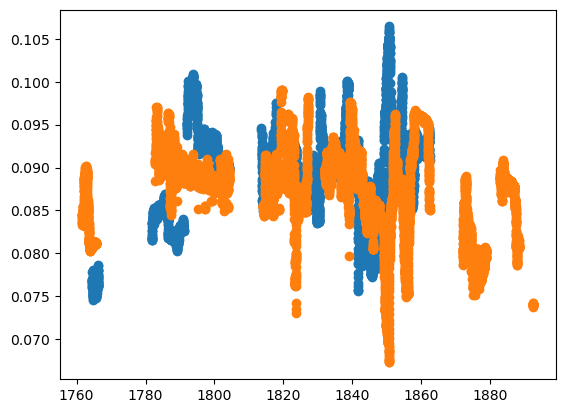

C:\Users\Gaelle_V\AppData\Local\Temp\ipykernel_12436\4025806545.py:6: RuntimeWarning: invalid value encountered in divide
  v_x_y_z = [t_x_y_z[:,1]/t_x_y_z[:,0], t_x_y_z[:,2]/t_x_y_z[:,0], t_x_y_z[:,3]/t_x_y_z[:,0]]


(8196,)
(9591,)


ValueError: operands could not be broadcast together with shapes (8196,) (9591,) 

In [15]:
subjects=[1,19, 23,7, 24, 26, 10, 13, 16, 17, 20, 27]
i=0
for subject in subjects:
    #select data points corresponding to the main task
    selected_nh,selected_tw = run_step1_per_subject(subject,i)

    #cut the time points in stitches
    dict_segment_time = full_segments_time[i]
    list_np_segmented_tw_rec = pd_2_numpy_and_segment(selected_tw, dict_segment_time)
    list_np_segmented_nh_rec = pd_2_numpy_and_segment(selected_nh, dict_segment_time)

    df_metrics = get_features_simplified(subject, i, list_np_segmented_tw_rec, list_np_segmented_nh_rec, save =False)
    print(subject)
    print(df_metrics)
    i=i+1